In [ ]:
!pip install pydub

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import LSTM,Dense,Dropout,Bidirectional,BatchNormalization,Conv2D,MaxPooling2D,Flatten,Layer,MultiHeadAttention,LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import auc,precision_recall_fscore_support, accuracy_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
def load_dataset():
    data_dir = './dataset'
    (train_data, validation_data, test_data), dataset_info = tfds.load(
        'speech_commands',
        split=['train', 'validation', 'test'],
        with_info=True,
        as_supervised=True,
        download=True,
        data_dir=data_dir
    )
    print(f"Dataset info: {dataset_info}")
    return train_data, validation_data, test_data

def preprocess_dataset(dataset):
    def preprocess(audio, label):
        audio = tf.cast(audio, tf.float32) / 32768.0  # Normalize 16-bit PCM encoding
        stft = tf.signal.stft(audio, frame_length=256, frame_step=128, fft_length=256)
        spectrogram = tf.abs(stft)
        num_spectrogram_bins = stft.shape[-1]
        linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
            80, num_spectrogram_bins, 16000, 80.0, 7600.0)
        mel_spectrogram = tf.tensordot(
            spectrogram, linear_to_mel_weight_matrix, 1)
        mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(
            linear_to_mel_weight_matrix.shape[-1:]))
        log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
        mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)[..., :13]
        return mfccs, label

    # Use padded_batch to ensure all sequences in the batch have the same length
    return dataset.map(preprocess).padded_batch(32, padded_shapes=([None, 13], []))


In [ ]:
train_data, validation_data, test_data = load_dataset()
train_data = preprocess_dataset(train_data)
validation_data = preprocess_dataset(validation_data)
test_data = preprocess_dataset(test_data)

def add_channel_dim(image, label):
    image = tf.expand_dims(image, -1)
    return image, label

train_data_CNN = train_data.map(add_channel_dim)    #Because CNN input requires an additional dimension to represent the number of channels.
validation_data_CNN = validation_data.map(add_channel_dim)
test_data_CNN = test_data.map(add_channel_dim)

Dataset info: tfds.core.DatasetInfo(
    name='speech_commands',
    full_name='speech_commands/0.0.3',
    description="""
    An audio dataset of spoken words designed to help train and evaluate keyword
    spotting systems. Its primary goal is to provide a way to build and test small
    models that detect when a single word is spoken, from a set of ten target words,
    with as few false positives as possible from background noise or unrelated
    speech. Note that in the train and validation set, the label "unknown" is much
    more prevalent than the labels of the target words or background noise. One
    difference from the release version is the handling of silent segments. While in
    the test set the silence segments are regular 1 second files, in the training
    they are provided as long segments under "background_noise" folder. Here we
    split these background noise into 1 second clips, and also keep one of the files
    for the validation set.
    """,
    homepage='ht

In [ ]:
def RNN(input_shape):
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True, input_shape=input_shape)),
        Dropout(0.5),
        BatchNormalization(),
        Bidirectional(LSTM(128)),
        Dropout(0.5),
        Dense(12, activation='softmax')  # 12 is the number of classes in the Speech Commands dataset
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model
input_shape_r = (None, 13)
model_r = RNN(input_shape_r)

In [ ]:
# Transformer Encoder Layer
class TransformerEncoderLayer(Layer):
    def __init__(self, d_model, num_heads, dff, rate):
        super(TransformerEncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(dff // 2, activation='relu'),  # Point-wise feed-forward network
            Dense(d_model)
        ])

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)

        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, x, training):
        attn_output = self.mha(x, x)  # Self-attention
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

# Complete Transformer Model
class Transformer(Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_shape, num_classes, rate=0.01):
        super(Transformer, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = Dense(d_model, activation='linear')
        self.enc_layers = [TransformerEncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]

        self.final_layer = Dense(num_classes, activation='softmax')

    def call(self, x, training):
        # Adding embedding and position encoding.
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training)
        x = tf.reduce_mean(x, axis=1)
        return self.final_layer(x)

num_layers = 2
d_model = 64
num_heads = 4
dff = 256
input_shape = (124,13)
num_classes = 12

model_t = Transformer(num_layers, d_model, num_heads, dff, input_shape, num_classes)
model_t.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
input_shape_CNN=(124,13,1)
def CNN(input_shape, num_classes=12):
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        Flatten(),

        Dense(256, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])
    return model

# Set up the model
model_c = CNN(input_shape=input_shape_CNN)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, verbose=1)

# Train the model
history_c = model_c.fit(train_data_CNN, validation_data=validation_data_CNN, epochs=20, callbacks=[early_stopping, model_checkpoint])
history_t = model_t.fit(train_data, validation_data=validation_data, epochs=20, callbacks=[early_stopping, model_checkpoint])
history_r = model_r.fit(train_data, validation_data=validation_data, epochs=20, callbacks=[early_stopping, model_checkpoint])
# Evaluate the model
test_loss_c, test_accuracy_c = model_c.evaluate(test_data_CNN)
test_loss_r, test_accuracy_r = model_r.evaluate(test_data)
test_loss_t, test_accuracy_t = model_t.evaluate(test_data)

Epoch 1/20
2673/2673 [==============================] - ETA: 0s - loss: 1.1111 - accuracy: 0.6635
Epoch 1: val_loss improved from inf to 0.62317, saving model to best_model.h5
2673/2673 [==============================] - 56s 14ms/step - loss: 1.1111 - accuracy: 0.6635 - val_loss: 0.6232 - val_accuracy: 0.8177


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/20
2673/2673 [==============================] - ETA: 0s - loss: 0.6864 - accuracy: 0.7745
Epoch 2: val_loss did not improve from 0.62317
2673/2673 [==============================] - 26s 10ms/step - loss: 0.6864 - accuracy: 0.7745 - val_loss: 0.6309 - val_accuracy: 0.8563
Epoch 3/20
2672/2673 [============================>.] - ETA: 0s - loss: 0.5433 - accuracy: 0.8237
Epoch 3: val_loss improved from 0.62317 to 0.34860, saving model to best_model.h5
2673/2673 [==============================] - 26s 10ms/step - loss: 0.5433 - accuracy: 0.8237 - val_loss: 0.3486 - val_accuracy: 0.8993
Epoch 4/20
2666/2673 [============================>.] - ETA: 0s - loss: 0.4720 - accuracy: 0.8473
Epoch 4: val_loss improved from 0.34860 to 0.28588, saving model to best_model.h5
2673/2673 [==============================] - 26s 10ms/step - loss: 0.4722 - accuracy: 0.8472 - val_loss: 0.2859 - val_accuracy: 0.9160
Epoch 5/20
2667/2673 [============================>.] - ETA: 0s - loss: 0.4272 - accuracy:

In [ ]:
y_true = np.concatenate([y.numpy() for x, y in test_data], axis=0)
y_pred_c_probs = np.concatenate([model_c.predict(x) for x, y in test_data_CNN], axis=0)
y_pred_r_probs = np.concatenate([model_r.predict(x) for x, y in test_data], axis=0)
y_pred_t_probs = np.concatenate([model_t.predict(x) for x, y in test_data], axis=0)

y_pred_c = np.argmax(y_pred_c_probs, axis=1)
y_pred_r = np.argmax(y_pred_r_probs, axis=1)
y_pred_t = np.argmax(y_pred_t_probs, axis=1)

1/1 [==============================] - 0s 25ms/step


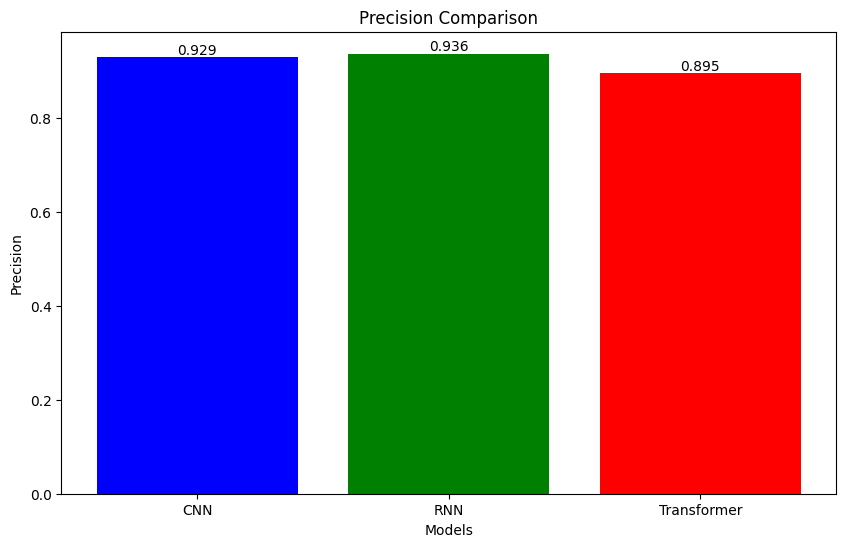

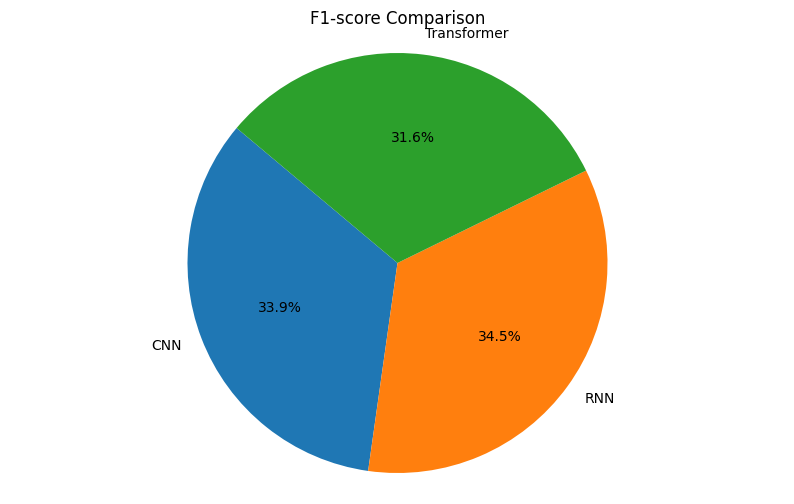

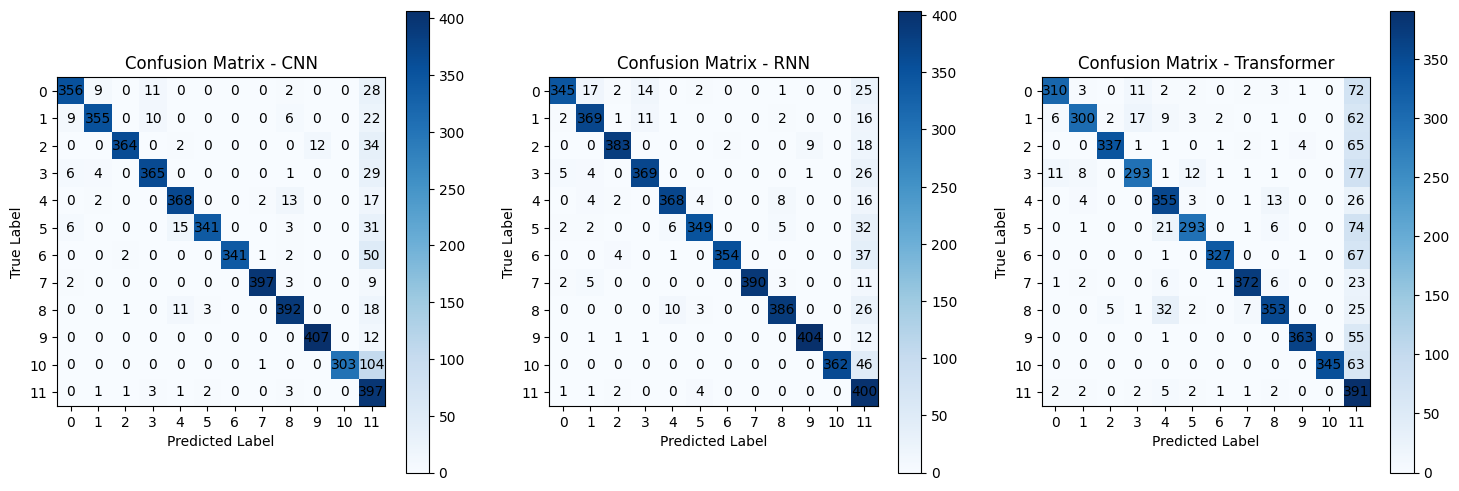

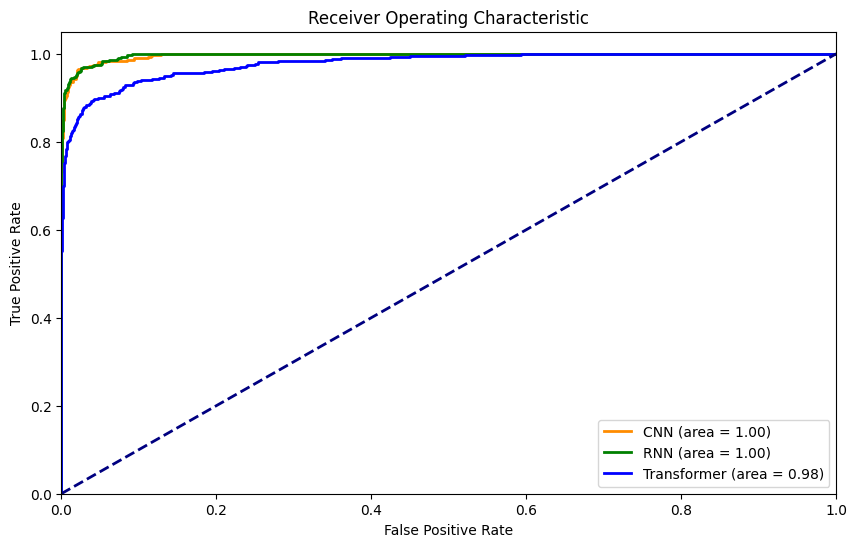

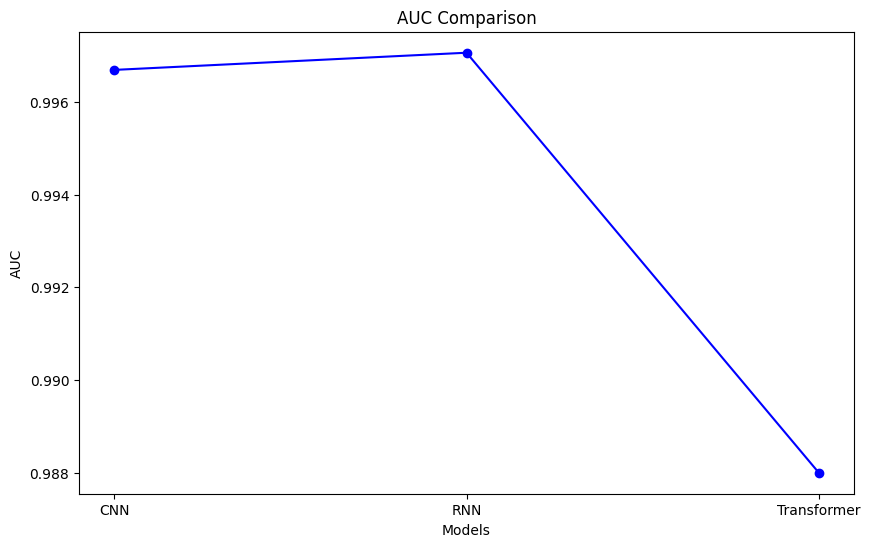

In [ ]:
def compute_metrics(y_true, y_pred, y_pred_probs):
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred_probs, multi_class='ovr')
    return precision, recall, f1_score, accuracy, auc_score

metrics_c = compute_metrics(y_true, y_pred_c, y_pred_c_probs)
metrics_r = compute_metrics(y_true, y_pred_r, y_pred_r_probs)
metrics_t = compute_metrics(y_true, y_pred_t, y_pred_t_probs)

labels = ['Precision', 'Recall', 'F1-score', 'Accuracy', 'AUC']
metrics = {
    'CNN': metrics_c,
    'RNN': metrics_r,
    'Transformer': metrics_t
}

# 1. Precision Bar Chart
plt.figure(figsize=(10, 6))
x = np.arange(len(metrics))
precision_values = [metrics['CNN'][0], metrics['RNN'][0], metrics['Transformer'][0]]
bars = plt.bar(x, precision_values, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Precision')
plt.title('Precision Comparison')
plt.xticks(x, ['CNN', 'RNN', 'Transformer'])
for bar, value in zip(bars, precision_values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(value, 3), ha='center', va='bottom')
plt.show()

# 2. F1-score Pie Chart
plt.figure(figsize=(10, 6))
f1_values = [metrics['CNN'][2], metrics['RNN'][2], metrics['Transformer'][2]]
plt.pie(f1_values, labels=['CNN', 'RNN', 'Transformer'], autopct='%1.1f%%', startangle=140)
plt.title('F1-score Comparison')
plt.axis('equal')
plt.show()

# 3. Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, model_name, ax):
    cm = confusion_matrix(y_true, y_pred)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(f'Confusion Matrix - {model_name}')
    tick_marks = np.arange(len(set(y_true)))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(tick_marks)
    ax.set_yticklabels(tick_marks)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
    return im

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
im1 = plot_confusion_matrix(y_true, y_pred_c, 'CNN', axes[0])
im2 = plot_confusion_matrix(y_true, y_pred_r, 'RNN', axes[1])
im3 = plot_confusion_matrix(y_true, y_pred_t, 'Transformer', axes[2])
fig.colorbar(im1, ax=axes[0])
fig.colorbar(im2, ax=axes[1])
fig.colorbar(im3, ax=axes[2])
plt.show()

# 4. ROC Curve
plt.figure(figsize=(10, 6))
def plot_roc_curve(y_true, y_pred_probs, model_name, color):
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{model_name} (area = {roc_auc:.2f})')

plot_roc_curve(y_true, y_pred_c_probs, 'CNN', 'darkorange')
plot_roc_curve(y_true, y_pred_r_probs, 'RNN', 'green')
plot_roc_curve(y_true, y_pred_t_probs, 'Transformer', 'blue')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 5. AUC Comparison Line Chart
plt.figure(figsize=(10, 6))
auc_values = [metrics['CNN'][4], metrics['RNN'][4], metrics['Transformer'][4]]
plt.plot(['CNN', 'RNN', 'Transformer'], auc_values, marker='o', linestyle='-', color='b')
plt.xlabel('Models')
plt.ylabel('AUC')
plt.title('AUC Comparison')
plt.show()